In [ ]:
#https://astronn.readthedocs.io/en/latest/galaxy10.html
!pip install astroNN

In [79]:
#https://arxiv.org/pdf/2102.08414.pdf

In [80]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from astroNN.datasets import load_galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup

## 1. Preprocessing

In [81]:
images, labels = load_galaxy10()

/root/.astroNN/datasets/Galaxy10.h5 was found!


In [82]:
images.shape

(21785, 69, 69, 3)

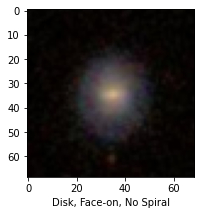

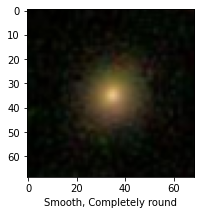

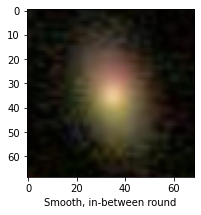

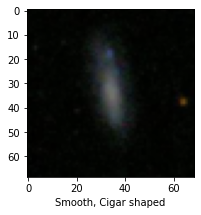

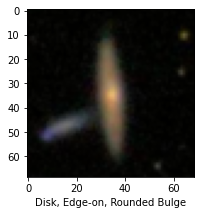

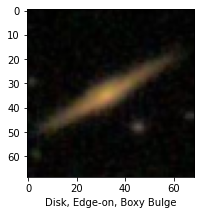

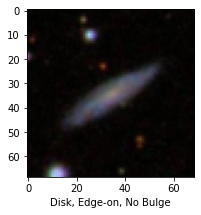

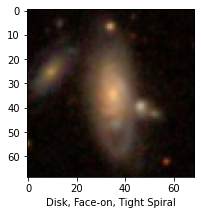

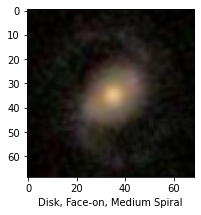

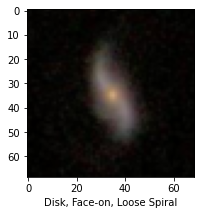

In [83]:
#Classe des galaxies avec illustration
for i in range(10):
  j=0
  while labels[j]!=i:
    j=j+1
  plt.figure(figsize=(3,4))
  plt.xlabel(galaxy10cls_lookup(i))
  plt.imshow(images[j])
  #if i==8:
  #  plt.savefig("Spiral.jpg")
  #  files.download("Spiral.jpg")
  #if i==6:
  #  plt.savefig("EdgeOn.jpg")
  #  files.download("EdgeOn.jpg")

In [84]:
#Nombre d'observation par classe
pd.DataFrame(labels).value_counts()

1    6997
2    6292
0    3461
4    1534
7    1121
8     906
6     589
9     519
3     349
5      17
dtype: int64

In [85]:
#6 = Disk Edge on No Bulge
#8 = Medium spiral
Un = images[np.where(labels==6)[0]]
Med = images[np.where(labels==8)[0]]
Un_lab = labels[np.where(labels==6)[0]]
Med_lab = labels[np.where(labels==8)[0]]

Un_lab = np.where(Un_lab==6, 0, Un_lab)
Med_lab = np.where(Med_lab==8, 1, Med_lab)

X = np.concatenate((Un, Med))
Y = np.concatenate((Un_lab, Med_lab))

In [86]:
Y.shape

(1495,)

In [87]:
from sklearn.model_selection import train_test_split

In [88]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, stratify=Y, test_size=0.3)

In [89]:
print(Ytrain.shape)
print(Ytest.shape)

(1046,)
(449,)


## 2.1 Premier Modèle

In [90]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, GlobalMaxPooling2D, Flatten, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [91]:
def create_model(CNN = 4, dense=2, drop=0.2):
  #CNN : Nombre de couches Convolutional (1 à 4)
  #dense : Nombre de couches Dense (2 à 8) (Nb pair pour qu'il y ait une succession de couche linéaire et non linéaire)
  #drop : taux de dropout
  model = Sequential()

  model.add(Conv2D(32, (3,3), activation = 'relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(drop))

  if CNN > 1:
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(drop))

  if CNN > 2:
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(drop))

  if CNN > 3:
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(drop))

  model.add(GlobalMaxPooling2D())
  model.add(Flatten())
  model.add(Dropout(drop))

  model.add(Dense(512, activation='relu'))

  if dense > 2:
    model.add(Dense(256, activation='linear'))
    model.add(Dense(128, activation='relu'))

  if dense > 4:
    model.add(Dense(64, activation='linear'))
    model.add(Dense(32, activation='relu'))

  if dense > 6:
    model.add(Dense(16, activation='linear'))
    model.add(Dense(8, activation='relu'))

  model.add(Dense(2, activation='sigmoid'))

  return model

In [92]:
def get_results(CNN=4, dense=2, drop=0.2, lr=0.01, batch=256, epochs=20):
  model = create_model(CNN=CNN, dense=dense, drop=drop)
  opti = tf.keras.optimizers.SGD(learning_rate=lr)
  model.compile(loss='sparse_categorical_crossentropy', optimizer=opti)
  tensor_X = tf.convert_to_tensor(Xtrain, dtype=tf.float64)
  tensor_Y = tf.convert_to_tensor(Ytrain, dtype=tf.int32)
  history = model.fit(tensor_X, tensor_Y, batch_size=batch, epochs=epochs, shuffle=True)
  pred = model.predict(Xtest)
  Pred=[]
  for i in range(pred.shape[0]):
    if pred[i,0]<pred[i,1]:
      Pred.append(1)
    else:
      Pred.append(0)
  print("CNN : ", CNN)
  print("Dense : ", dense)
  print("Dropout : ", drop)
  print("Lr : ", lr)
  print("Batch : ", batch)
  print("Epochs : ", epochs)
  print("accuracy", accuracy_score(Ytest, Pred))
  print("")
  return accuracy_score(Ytest, Pred)

### Test des hyperparamètres

#### Nombres de couches CNN

Epoch 1/20
5/5 [==============================] - 1s 36ms/step - loss: 14.9753
Epoch 2/20
5/5 [==============================] - 0s 34ms/step - loss: 1.8761
Epoch 3/20
5/5 [==============================] - 0s 32ms/step - loss: 1.1787
Epoch 4/20
5/5 [==============================] - 0s 32ms/step - loss: 1.4002
Epoch 5/20
5/5 [==============================] - 0s 31ms/step - loss: 0.9428
Epoch 6/20
5/5 [==============================] - 0s 29ms/step - loss: 1.0176
Epoch 7/20
5/5 [==============================] - 0s 32ms/step - loss: 1.3430
Epoch 8/20
5/5 [==============================] - 0s 34ms/step - loss: 0.7737
Epoch 9/20
5/5 [==============================] - 0s 28ms/step - loss: 0.6958
Epoch 10/20
5/5 [==============================] - 0s 30ms/step - loss: 0.7905
Epoch 11/20
5/5 [==============================] - 0s 30ms/step - loss: 0.7488
Epoch 12/20
5/5 [==============================] - 0s 30ms/step - loss: 0.7161
Epoch 13/20
5/5 [==============================] - 0s 31ms/s

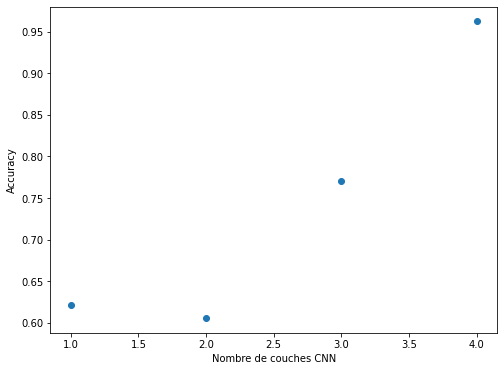

In [123]:
a = get_results(CNN=1)
b = get_results(CNN=2)
c = get_results(CNN=3)
d = get_results(CNN=4)
plt.figure(figsize=(8,6))
plt.xlabel("Nombre de couches CNN")
plt.ylabel("Accuracy")
plt.scatter(np.array([1,2,3,4]),np.array([a,b,c,d]))

#### Nombre de couches Dense

Epoch 1/20
5/5 [==============================] - 1s 57ms/step - loss: 1.9292
Epoch 2/20
5/5 [==============================] - 0s 48ms/step - loss: 0.5163
Epoch 3/20
5/5 [==============================] - 0s 50ms/step - loss: 0.3185
Epoch 4/20
5/5 [==============================] - 0s 48ms/step - loss: 0.1820
Epoch 5/20
5/5 [==============================] - 0s 49ms/step - loss: 0.1714
Epoch 6/20
5/5 [==============================] - 0s 49ms/step - loss: 0.1588
Epoch 7/20
5/5 [==============================] - 0s 49ms/step - loss: 0.1254
Epoch 8/20
5/5 [==============================] - 0s 50ms/step - loss: 0.0989
Epoch 9/20
5/5 [==============================] - 0s 48ms/step - loss: 0.0705
Epoch 10/20
5/5 [==============================] - 0s 49ms/step - loss: 0.0791
Epoch 11/20
5/5 [==============================] - 0s 48ms/step - loss: 0.0789
Epoch 12/20
5/5 [==============================] - 0s 49ms/step - loss: 0.0619
Epoch 13/20
5/5 [==============================] - 0s 48ms/st

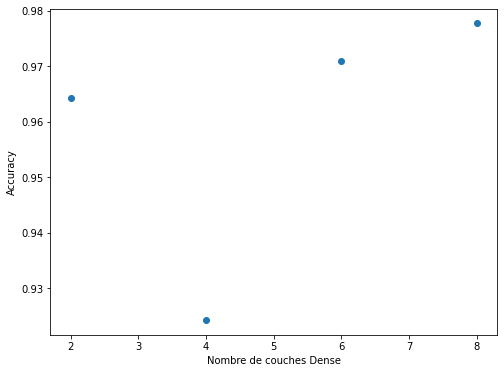

In [124]:
a = get_results(dense=2)
b = get_results(dense=4)
c = get_results(dense=6)
d = get_results(dense=8)
plt.figure(figsize=(8,6))
plt.xlabel("Nombre de couches Dense")
plt.ylabel("Accuracy")
plt.scatter(np.array([2,4,6,8]),np.array([a,b,c,d]))

#### Taux de dropout

Epoch 1/20
5/5 [==============================] - 1s 45ms/step - loss: 1.2318
Epoch 2/20
5/5 [==============================] - 0s 46ms/step - loss: 0.4070
Epoch 3/20
5/5 [==============================] - 0s 46ms/step - loss: 0.0828
Epoch 4/20
5/5 [==============================] - 0s 44ms/step - loss: 0.0700
Epoch 5/20
5/5 [==============================] - 0s 45ms/step - loss: 0.0425
Epoch 6/20
5/5 [==============================] - 0s 45ms/step - loss: 0.0355
Epoch 7/20
5/5 [==============================] - 0s 45ms/step - loss: 0.0312
Epoch 8/20
5/5 [==============================] - 0s 47ms/step - loss: 0.0454
Epoch 9/20
5/5 [==============================] - 0s 45ms/step - loss: 0.0245
Epoch 10/20
5/5 [==============================] - 0s 48ms/step - loss: 0.0196
Epoch 11/20
5/5 [==============================] - 0s 46ms/step - loss: 0.0227
Epoch 12/20
5/5 [==============================] - 0s 46ms/step - loss: 0.0247
Epoch 13/20
5/5 [==============================] - 0s 47ms/st

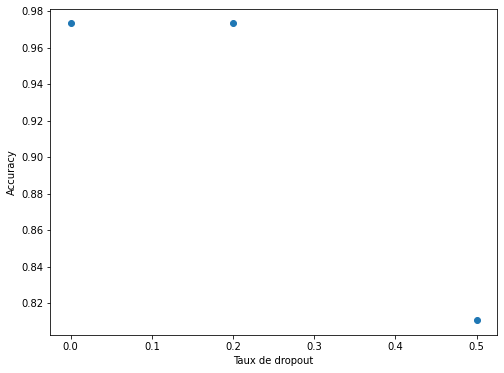

In [95]:
a = get_results(drop=0)
b = get_results(drop=0.2)
c = get_results(drop=0.5)
plt.figure(figsize=(8,6))
plt.xlabel("Taux de dropout")
plt.ylabel("Accuracy")
plt.scatter(np.array([0,0.2,0.5]),np.array([a,b,c]))

#### Taux d'apprentissage

Epoch 1/20
5/5 [==============================] - 1s 48ms/step - loss: 1.2176
Epoch 2/20
5/5 [==============================] - 0s 49ms/step - loss: 0.3670
Epoch 3/20
5/5 [==============================] - 0s 49ms/step - loss: 0.3077
Epoch 4/20
5/5 [==============================] - 0s 48ms/step - loss: 0.1891
Epoch 5/20
5/5 [==============================] - 0s 48ms/step - loss: 0.1628
Epoch 6/20
5/5 [==============================] - 0s 48ms/step - loss: 0.1133
Epoch 7/20
5/5 [==============================] - 0s 47ms/step - loss: 0.1019
Epoch 8/20
5/5 [==============================] - 0s 49ms/step - loss: 0.1282
Epoch 9/20
5/5 [==============================] - 0s 49ms/step - loss: 0.1082
Epoch 10/20
5/5 [==============================] - 0s 47ms/step - loss: 0.0915
Epoch 11/20
5/5 [==============================] - 0s 48ms/step - loss: 0.1302
Epoch 12/20
5/5 [==============================] - 0s 48ms/step - loss: 0.1210
Epoch 13/20
5/5 [==============================] - 0s 49ms/st

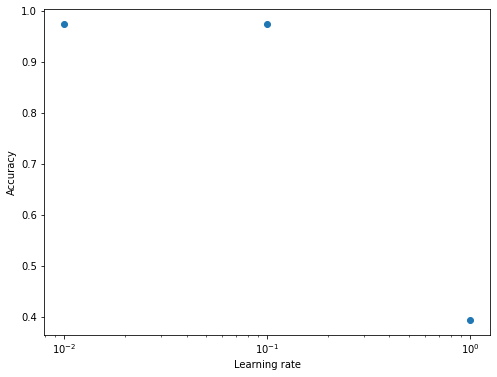

In [96]:
a = get_results(lr=0.01)
b = get_results(lr=0.1)
c = get_results(lr=1)
plt.figure(figsize=(8,6))
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.gca().set_xscale('log')
plt.scatter(np.array([0.01,0.1,1]),np.array([a,b,c]))

#### Taille du batch

Epoch 1/20
17/17 [==============================] - 1s 23ms/step - loss: 0.8597
Epoch 2/20
17/17 [==============================] - 0s 19ms/step - loss: 0.1537
Epoch 3/20
17/17 [==============================] - 0s 22ms/step - loss: 0.1366
Epoch 4/20
17/17 [==============================] - 0s 17ms/step - loss: 0.1115
Epoch 5/20
17/17 [==============================] - 0s 16ms/step - loss: 0.0804
Epoch 6/20
17/17 [==============================] - 0s 16ms/step - loss: 0.0697
Epoch 7/20
17/17 [==============================] - 0s 16ms/step - loss: 0.0768
Epoch 8/20
17/17 [==============================] - 0s 16ms/step - loss: 0.0566
Epoch 9/20
17/17 [==============================] - 0s 16ms/step - loss: 0.0419
Epoch 10/20
17/17 [==============================] - 0s 16ms/step - loss: 0.0373
Epoch 11/20
17/17 [==============================] - 0s 16ms/step - loss: 0.0664
Epoch 12/20
17/17 [==============================] - 0s 16ms/step - loss: 0.0599
Epoch 13/20
17/17 [==================

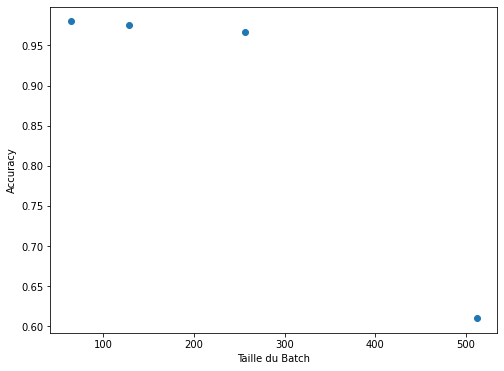

In [125]:
a = get_results(batch=64)
b = get_results(batch=128)
c = get_results(batch=256)
d = get_results(batch=512)
plt.figure(figsize=(8,6))
plt.xlabel("Taille du Batch")
plt.ylabel("Accuracy")
plt.scatter(np.array([64,128,256,512]),np.array([a,b,c,d]))

#### Nombre d'époques

15/15 [==============================] - 0s 3ms/step
CNN :  4
Dense :  2
Dropout :  0.2
Lr :  0.01
Batch :  256
Epochs :  1
accuracy 0.6057906458797327

Epoch 1/20
5/5 [==============================] - 1s 49ms/step - loss: 1.6026
Epoch 2/20
5/5 [==============================] - 0s 49ms/step - loss: 0.3880
Epoch 3/20
5/5 [==============================] - 0s 49ms/step - loss: 0.2020
Epoch 4/20
5/5 [==============================] - 0s 49ms/step - loss: 0.2029
Epoch 5/20
5/5 [==============================] - 0s 48ms/step - loss: 0.1691
Epoch 6/20
5/5 [==============================] - 0s 48ms/step - loss: 0.1370
Epoch 7/20
5/5 [==============================] - 0s 48ms/step - loss: 0.1423
Epoch 8/20
5/5 [==============================] - 0s 49ms/step - loss: 0.0930
Epoch 9/20
5/5 [==============================] - 0s 48ms/step - loss: 0.0856
Epoch 10/20
5/5 [==============================] - 0s 48ms/step - loss: 0.0924
Epoch 11/20
5/5 [==============================] - 0s 50ms/step - 

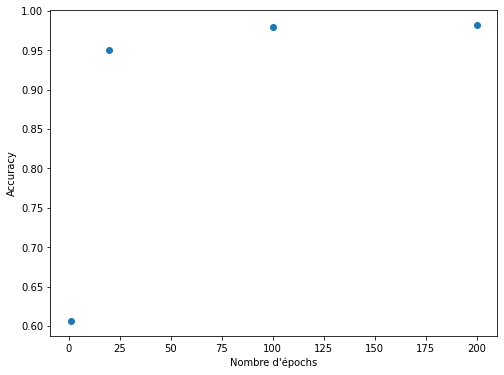

In [128]:
a = get_results(epochs=1)
b = get_results(epochs=20)
c = get_results(epochs=100)
d = get_results(epochs=200)
plt.figure(figsize=(8,6))
plt.xlabel("Nombre d'épochs")
plt.ylabel("Accuracy")
plt.scatter(np.array([1,20,100,200]),np.array([a,b,c,d]))

## 2.2 Modèles pré entraînés 




In [99]:
from tensorflow.keras.applications import resnet50, vgg16
from tensorflow.keras import Model, Input

### Resnet50

In [100]:
mod = resnet50.ResNet50(include_top=False,input_shape=(69,69,3))

for layer in mod.layers:
  layer.trainable = False

input = Input(shape=(69,69,3))
resnet = mod(input)
gmp = GlobalMaxPooling2D()(resnet)
flat = Flatten()(gmp)
dropout = Dropout(0.2)(flat)
dense1 = Dense(512, activation='relu')(dropout)
output = Dense(2, activation='sigmoid')(dense1)

94765736/94765736 [==============================] - 5s 0us/step


In [101]:
model = Model(inputs=input, outputs=output)

In [102]:
tensor_X = tf.convert_to_tensor(Xtrain, dtype=tf.float64)
tensor_Y = tf.convert_to_tensor(Ytrain, dtype=tf.int32)

opti = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opti)
model.fit(tensor_X, tensor_Y, batch_size=256, epochs=20, shuffle=True)

Epoch 1/20
5/5 [==============================] - 5s 183ms/step - loss: 3.6774
Epoch 2/20
5/5 [==============================] - 0s 94ms/step - loss: 0.0667
Epoch 3/20
5/5 [==============================] - 0s 93ms/step - loss: 0.0477
Epoch 4/20
5/5 [==============================] - 0s 93ms/step - loss: 0.0388
Epoch 5/20
5/5 [==============================] - 0s 93ms/step - loss: 0.0306
Epoch 6/20
5/5 [==============================] - 0s 94ms/step - loss: 0.0306
Epoch 7/20
5/5 [==============================] - 0s 93ms/step - loss: 0.0367
Epoch 8/20
5/5 [==============================] - 0s 93ms/step - loss: 0.0265
Epoch 9/20
5/5 [==============================] - 0s 92ms/step - loss: 0.0176
Epoch 10/20
5/5 [==============================] - 0s 93ms/step - loss: 0.0238
Epoch 11/20
5/5 [==============================] - 0s 94ms/step - loss: 0.0219
Epoch 12/20
5/5 [==============================] - 0s 94ms/step - loss: 0.0212
Epoch 13/20
5/5 [==============================] - 0s 94ms/s

In [103]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 69, 69, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_max_pooling2d_23 (Gl  (None, 2048)             0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_23 (Flatten)        (None, 2048)              0         
                                                                 
 dropout_105 (Dropout)       (None, 2048)              0         
                                                                 
 dense_58 (Dense)            (None, 512)               1049088   
                                                           

In [104]:
pred = model.predict(Xtest)
Pred=[]
for i in range(pred.shape[0]):
    if pred[i,0]<pred[i,1]:
      Pred.append(1)
    else:
      Pred.append(0)

15/15 [==============================] - 2s 38ms/step


In [105]:
accuracy_score(Ytest, Pred)

0.9755011135857461

### VGG16

In [106]:
mod = vgg16.VGG16(include_top=False,input_shape=(69,69,3))

for layer in mod.layers:
  layer.trainable = False

input = Input(shape=(69,69,3))
resnet = mod(input)
gmp = GlobalMaxPooling2D()(resnet)
flat = Flatten()(gmp)
dropout = Dropout(0.2)(flat)
dense1 = Dense(512, activation='relu')(dropout)
output = Dense(2, activation='sigmoid')(dense1)

In [107]:
model = Model(inputs=input, outputs=output)

In [108]:
tensor_X = tf.convert_to_tensor(Xtrain, dtype=tf.float64)
tensor_Y = tf.convert_to_tensor(Ytrain, dtype=tf.int32)

opti = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opti)
model.fit(tensor_X, tensor_Y, batch_size=256, epochs=20, shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 107ms/step - loss: 8.5262
Epoch 2/20
5/5 [==============================] - 1s 112ms/step - loss: 0.2356
Epoch 3/20
5/5 [==============================] - 1s 108ms/step - loss: 0.2375
Epoch 4/20
5/5 [==============================] - 1s 108ms/step - loss: 0.1293
Epoch 5/20
5/5 [==============================] - 1s 108ms/step - loss: 0.1682
Epoch 6/20
5/5 [==============================] - 1s 109ms/step - loss: 0.1761
Epoch 7/20
5/5 [==============================] - 1s 109ms/step - loss: 0.0621
Epoch 8/20
5/5 [==============================] - 1s 109ms/step - loss: 0.1055
Epoch 9/20
5/5 [==============================] - 1s 110ms/step - loss: 0.0801
Epoch 10/20
5/5 [==============================] - 1s 109ms/step - loss: 0.0881
Epoch 11/20
5/5 [==============================] - 1s 109ms/step - loss: 0.0808
Epoch 12/20
5/5 [==============================] - 1s 110ms/step - loss: 0.0493
Epoch 13/20
5/5 [==============================] 

In [109]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 69, 69, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_max_pooling2d_24 (Gl  (None, 512)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_24 (Flatten)        (None, 512)               0         
                                                                 
 dropout_106 (Dropout)       (None, 512)               0         
                                                                 
 dense_60 (Dense)            (None, 512)               262656    
                                                           

In [110]:
pred = model.predict(Xtest)
Pred=[]
for i in range(pred.shape[0]):
    if pred[i,0]<pred[i,1]:
      Pred.append(1)
    else:
      Pred.append(0)

15/15 [==============================] - 0s 22ms/step


In [111]:
accuracy_score(Ytest, Pred)

0.9933184855233853

## 2.4 Nouveau Dataset

In [112]:
#3 = Cigar shape
#9 = Loose spiral
Un = images[np.where(labels==3)[0]]
Med = images[np.where(labels==9)[0]]
Un_lab = labels[np.where(labels==3)[0]]
Med_lab = labels[np.where(labels==9)[0]]

Un_lab = np.where(Un_lab==3, 0, Un_lab)
Med_lab = np.where(Med_lab==9, 1, Med_lab)

X = np.concatenate((Un, Med))
Y = np.concatenate((Un_lab, Med_lab))

In [113]:
pred = model.predict(X)
Pred=[]
for i in range(pred.shape[0]):
    if pred[i,0]<pred[i,1]:
      Pred.append(1)
    else:
      Pred.append(0)
accuracy_score(Y, Pred)

28/28 [==============================] - 1s 19ms/step


0.8283410138248848

## 2.5 Robustesse du modèle

In [ ]:
#https://github.com/cleverhans-lab/cleverhans
!pip install cleverhans

In [115]:
#https://arxiv.org/pdf/1412.6572.pdf

In [116]:
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

In [137]:
def Attack(epsilon):  
  Xtest_adv = fast_gradient_method(
    model_fn=model,
    x=Xtest,
    eps=epsilon,
    norm=np.inf
  )
  Xtest_adv=tf.cast(Xtest_adv, tf.int64)

  plt.figure(figsize=(3,4))
  plt.xlabel(epsilon)
  plt.imshow(Xtest_adv[0])

  #plt.savefig("Attaque.jpg")
  #files.download("Attaque.jpg")

  pred = model.predict(Xtest_adv)
  Pred=[]
  for i in range(pred.shape[0]):
    if pred[i,0]<pred[i,1]:
      Pred.append(1)
    else:
      Pred.append(0)
  print("Epsilon : ",epsilon,"Accuracy : ", accuracy_score(Ytest, Pred))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

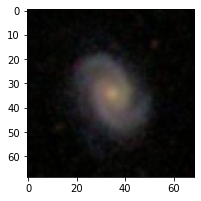

In [129]:
plt.figure(figsize=(3,4))
plt.imshow(Xtest[0])
#plt.savefig("Attaque.jpg")
#files.download("Attaque.jpg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

15/15 [==============================] - 0s 20ms/step
Epsilon :  0.1 Accuracy :  0.9287305122494433


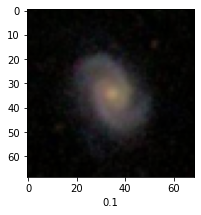

In [132]:
Attack(0.1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

15/15 [==============================] - 0s 20ms/step
Epsilon :  1 Accuracy :  0.8151447661469933


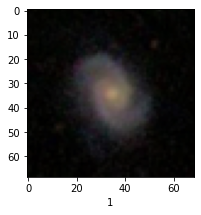

In [133]:
Attack(1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

15/15 [==============================] - 0s 20ms/step
Epsilon :  5 Accuracy :  0.5211581291759465


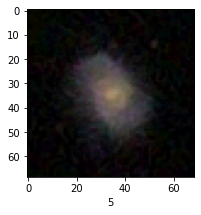

In [134]:
Attack(5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

15/15 [==============================] - 0s 20ms/step
Epsilon :  10 Accuracy :  0.5746102449888641


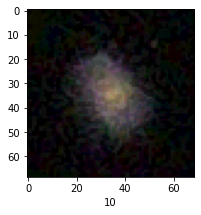

In [136]:
Attack(10)